## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll import all

In [1]:
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

from src.utils.cam_cal import *
from src.utils.image_utils import *
from src.utils.lane_lines import *
from src.utils.plt_utils import *

## compute the camera calibration using chessboard images

In [2]:
cam_cal_path = '../resources/camera_cal/'
# Run the next command the first time
# mtx, dist = calibrate_camera(9, 6, cam_cal_path, 'cali*.jpg')
pickle = pickle.load(open(cam_cal_path + CC_FILE, 'rb'))
mtx = pickle[CC_MTX]
dist = pickle[CC_DIST]

## Configure the settings for the process

In [3]:
settings.mtx = mtx
settings.dist = dist

## Apply a distortion correction to raw image

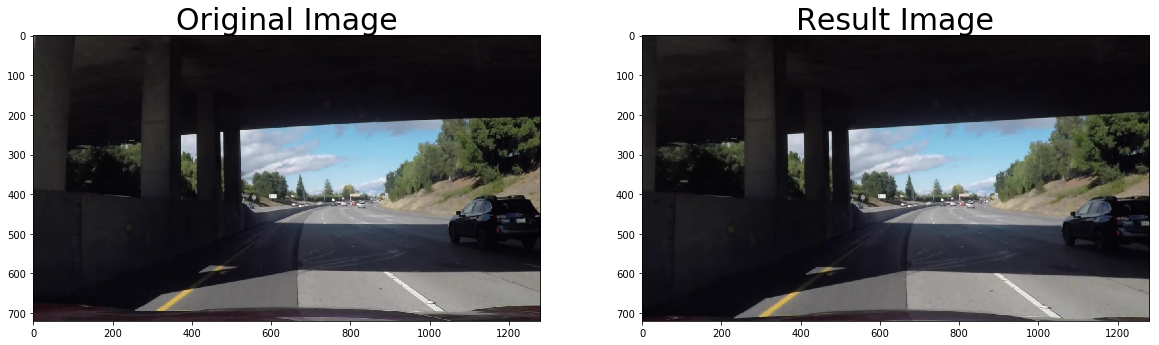

In [4]:
image = mpimg.imread('../resources/test_images/test00003.jpg')

img_un_dist = undistort_image(image, settings.mtx, settings.dist)
visualize_result(image, img_un_dist, show=False)

## Use color transforms, gradients, etc., to create a thresholded binary image.
### 1. get S channel with hls

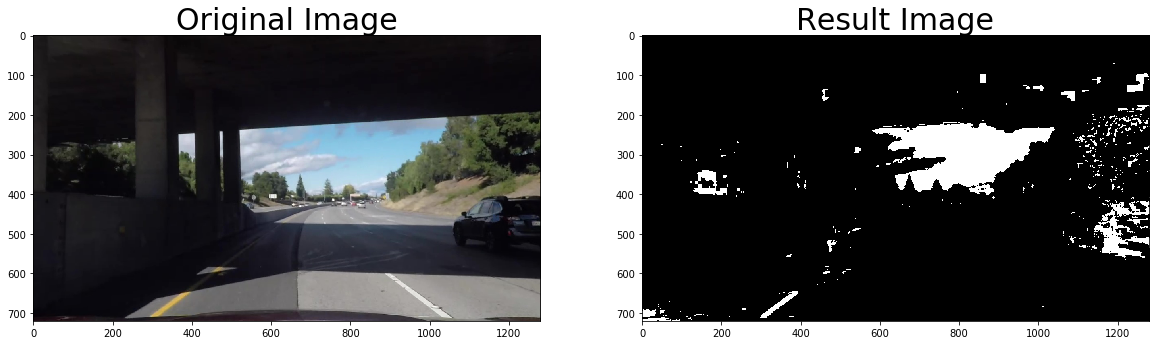

In [5]:
S_CHANNEL_THRESH = (80, 255)
img_s_binary = hls_select(img_un_dist, thresh=S_CHANNEL_THRESH)
visualize_result(img_un_dist, img_s_binary, gray=True, show=False)

### 2. get sobel gradient in x 

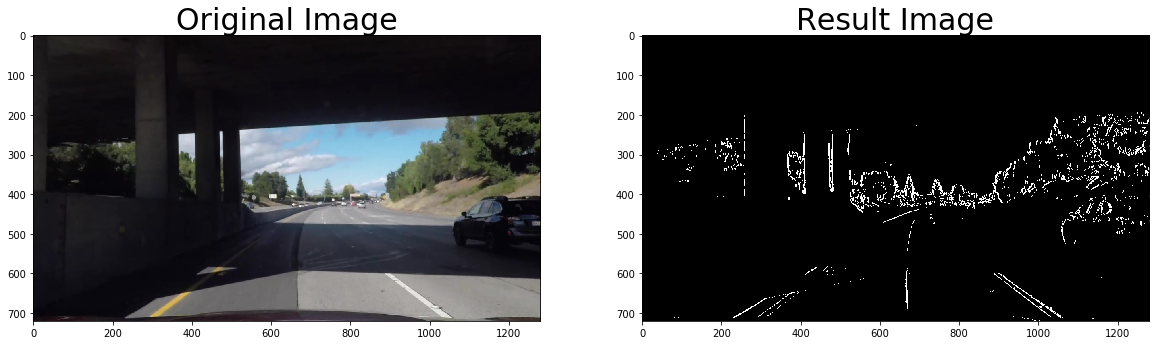

In [6]:
img_sxbinary = abs_sobel_thresh(img_un_dist, orient='x', sobel_kernel=KERNEL_SIZE, thresh=SOBEL_X_THRESH)
visualize_result(img_un_dist, img_sxbinary, gray=True, show=False)

### 3. combine s channel and sobel

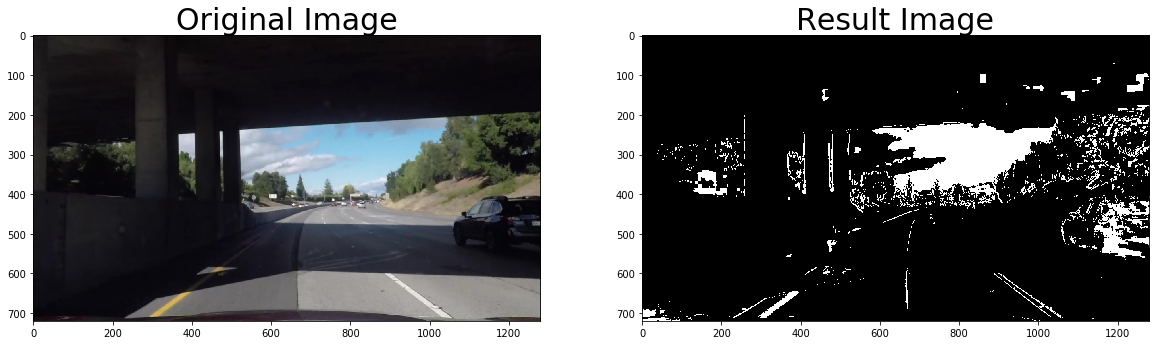

In [7]:
img_adv = advanced_transform(
    img_un_dist, kernel_size=KERNEL_SIZE, s_thresh=S_CHANNEL_THRESH, sx_thresh=SOBEL_X_THRESH
)
visualize_result(img_un_dist, img_adv, gray=True, show=False)

## Apply a perspective transform to rectify binary image ("birds-eye view")
### Calculate the area of interest (aoi) base on the image

In [16]:
settings.aoi_xmid = 0.511
settings.aoi_ymid = 0.61
settings.aoi_upsz = 0.015
settings.aoi_des = -35
settings.aoi_basesz = 0.350

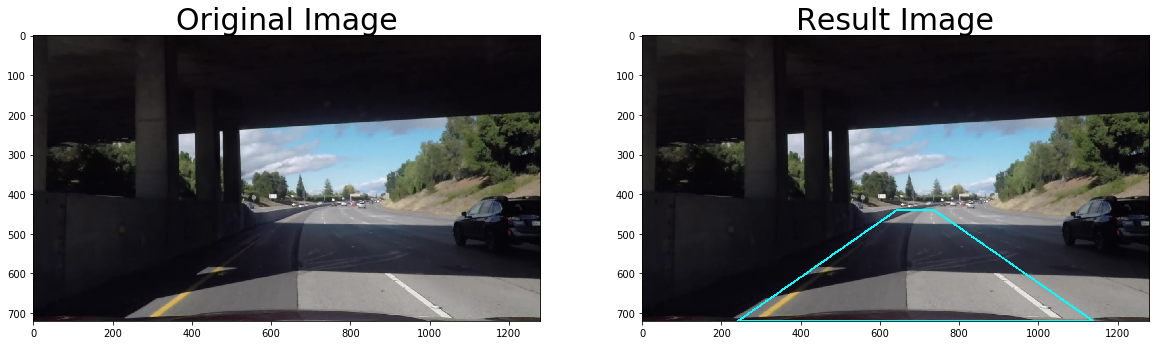

In [17]:
settings.find_aoi_src_dst(img_un_dist)
img_aoi_src = np.copy(img_un_dist)
cv2.polylines(img_aoi_src, [settings.aoi_src.astype(int)], True, color=(0, 255, 255), thickness=3)
visualize_result(img_un_dist, img_aoi_src, show=False)

### Apply bird eye perspective transform

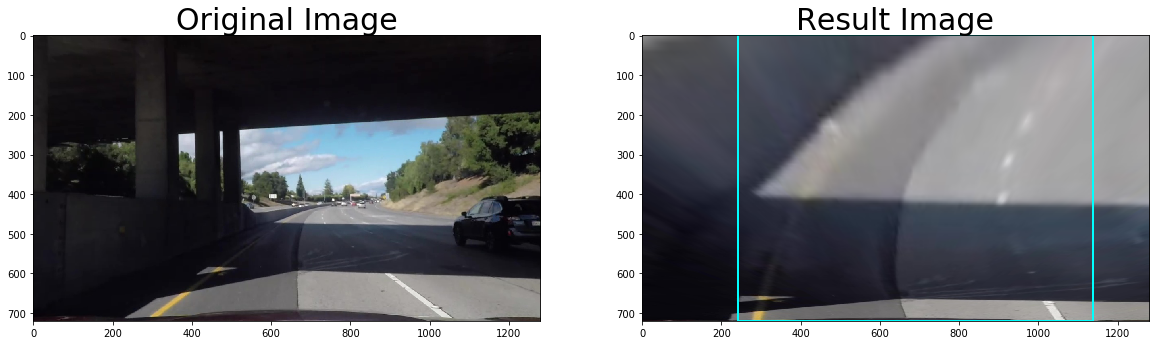

In [18]:
settings.find_aoi_src_dst(img_un_dist)
img_aoi = np.copy(img_un_dist)
img_bird_eye, minv = bird_eye_transform(img_aoi, settings.aoi_src, settings.bird_dst)
cv2.polylines(img_bird_eye, [settings.bird_dst.astype(int)], True, color=(0, 255, 255), thickness=3)
visualize_result(img_un_dist, img_bird_eye, show=False)

### adavance tranform to bird eye view 

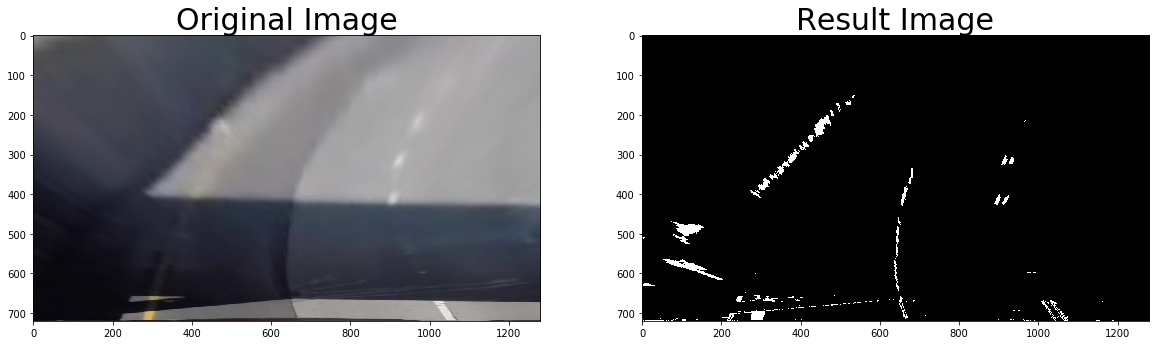

In [19]:
settings.find_aoi_src_dst(img_un_dist)
img_bird_eye, minv = bird_eye_transform(img_un_dist, settings.aoi_src, settings.bird_dst)
img_be_adv = advanced_transform(
    img_bird_eye, kernel_size=KERNEL_SIZE, s_thresh=S_CHANNEL_THRESH, sx_thresh=SOBEL_X_THRESH
)
visualize_result(img_bird_eye, img_be_adv, gray=True, show=False)

## Detect lane pixels and fit to find the lane boundary and calculate the curvature

Using sliding windows


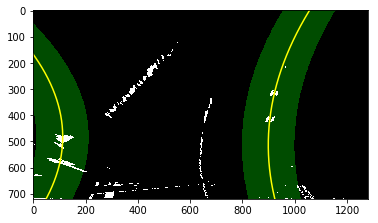

In [20]:
find_lane_lines_sliding_windows(img_be_adv)
sa_margin = int(SW_MARGIN // 2)
show_lines_on_image_test(img_be_adv, settings.left_glines, settings.right_glines, sa_margin)

### Detect the lane pixels using the last detention

Using sliding windows


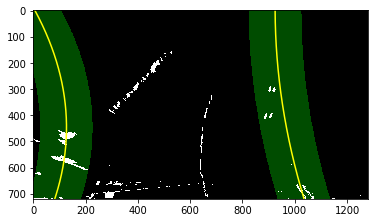

In [13]:
search_around_poly(img_be_adv)
sa_margin = int(SW_MARGIN // 2)
show_lines_on_image_test(img_be_adv, settings.left_glines, settings.right_glines, sa_margin)

### Determine the curvature of the lane and vehicle position with respect to center

In [14]:
print(settings.left_glines.radius_of_curvature, 'm', settings.right_glines.radius_of_curvature, 'm')
print(settings.offset, 'm')

159.087207436 m 790.305743421 m
0.897026230977 m


## Warp the detected lane boundaries back onto the original image

Using sliding windows


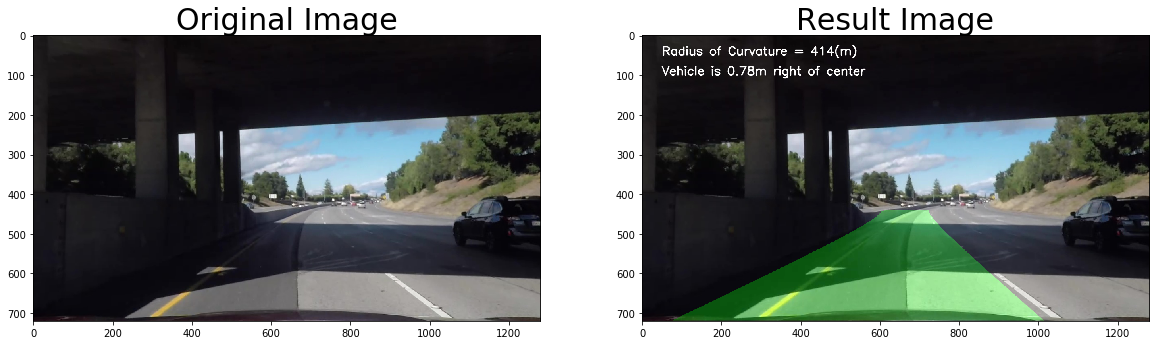

In [15]:
# 1. Un-distort the image to get better measure
un_dist = undistort_image(image, settings.mtx, settings.dist)
# 2. Apply the advanced transform to get the final image
img_adv = advanced_transform(
    un_dist, kernel_size=KERNEL_SIZE, s_thresh=S_CHANNEL_THRESH, sx_thresh=SOBEL_X_THRESH
)
# 3. Get the bird eye view and the invert transform matrix
binary_warped, minv = bird_eye_transform(img_adv, settings.aoi_src, settings.bird_dst)
# 4. Find the lane lines in the bird eye view, determine the curvature of the lane and vehicle position
find_lane_lines(binary_warped)
# 5. Draw the lines in the un-distorted image
result = draw_final_lines(
    binary_warped, minv, un_dist, settings.left_glines, settings.right_glines, settings.offset
)
visualize_result(img_un_dist, result, show=False)